In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
raw_df = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
df = pd.DataFrame(raw_df, columns=column_names)
df.tail(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [29]:
X = df.iloc[:,:-1].values  # желательно не оставлять Pandas !!! так как y_test - Pandas,  y_predict - numpy
y = df.iloc[:,-1].values

print(X.shape)
print(y.shape)

(506, 13)
(506,)


## 1. Строим самую простую модель

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)

sc_train = knn.score(X_train , y_train)
sc_test = knn.score(X_test , y_test)


print("тренировочный: {:.3f}".format(sc_train))
print("тестовый: {:.3f}".format(sc_test))

тренировочный: 0.699
тестовый: 0.653


## 2. Проводим препроцессинг (пересмасштабирование) данных

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

scaler = MinMaxScaler() # используем функцию масштабирования
scaler.fit(X_train)     # Перемасштабирование ТОЛЬКО на ТРЕНИРОВОЧНОМ наборе, создали правило перемасштабирования  

X_train_scaled = scaler.transform(X_train) # перемасштабировали тренировочный набор
X_test_scaled = scaler.transform(X_test)   # перемасштабировали тестовый набор


knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_scaled, y_train)

sc_train = knn.score(X_train_scaled , y_train)
sc_test =  knn.score(X_test_scaled ,  y_test)

print("тренировочный: {:.3f}".format(sc_train))
print("тестовый: {:.3f}".format(sc_test))

тренировочный: 0.867
тестовый: 0.729


## 3. Встроим пересмасштабирование данных в в кросс-валидацию и решетку.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit

val_score = cross_val_score(knn, X_train_scaled, y_train, cv = 5)

np.mean(val_score)

0.711108266160109

Какую ошибку мы совершаем? Что на счет утечки в данных? 

### 3.1 Строим контейнеры

In [7]:
from sklearn.pipeline import Pipeline

# Объявим контейнер и его составные части

pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor',     KNeighborsRegressor(n_neighbors=4))])

pipe

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=4))])

In [8]:
# В контейнер укладываем исходные данные
val_score = cross_val_score(pipe, X_train, y_train, cv = 5)
np.mean(val_score)

0.7083797673493519

### 3.2 Контейнер и решетка

Объявим, решим и визуализируем задачу целиком

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.25)

In [11]:
# Объявим контейнер, важно определить его позиции, которые мы сможем менять в решетки
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor',    KNeighborsRegressor())])

# определим кросс-валидацию
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Определим параметры для перебора по решетке

p = np.arange(1,5)
weights = ['uniform','distance']
n_neighbors = np.arange(1,10)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler() ]


# параметры решетки
param_grid =[
    {'preprocessing': scaling, 
     'regressor': [KNeighborsRegressor()],
         'regressor__n_neighbors': n_neighbors,
         'regressor__p': p,
         'regressor__weights': weights
     }]

grid = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)
grid.fit(X_train,y_train)
grid

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid=[{'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler()],
                          'regressor': [KNeighborsRegressor(n_neighbors=3, p=1,
                                                            weights='distance')],
                          'regressor__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'regressor__p': array([1, 2, 3, 4]),
                          'regressor__weights': ['uniform', 'distance']}],
             return_train_score=True)

In [12]:
print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на" 
      "валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'preprocessing': RobustScaler(), 'regressor': KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'), 'regressor__n_neighbors': 3, 'regressor__p': 1, 'regressor__weights': 'distance'}

Средняя правильность для наилучшей модели кроссвалидации навалидационных тестовых наборах: 0.829090

Правильность для наилучшей модели на тестовом наборе: 0.695948



In [13]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,161,89,91,160,105,97,169,88,81,113,...,44,46,66,58,52,54,68,60,62,70
mean_fit_time,0.00239,0.000839,0.000849,0.002384,0.000845,0.000827,0.002391,0.000844,0.000846,0.000851,...,0.00085,0.000786,0.00075,0.000743,0.000807,0.000788,0.000776,0.000767,0.000769,0.000805
std_fit_time,0.000088,0.000034,0.000018,0.000101,0.000018,0.000003,0.000105,0.000026,0.000017,0.000028,...,0.000059,0.000024,0.000047,0.000012,0.000022,0.000021,0.000034,0.000022,0.000017,0.000069
mean_score_time,0.000891,0.000797,0.000803,0.000837,0.000825,0.000805,0.000838,0.000772,0.000789,0.000848,...,0.002488,0.00229,0.000837,0.000844,0.002478,0.002389,0.002503,0.002407,0.002358,0.002436
std_score_time,0.000078,0.000015,0.000029,0.000054,0.00001,0.00001,0.000016,0.000015,0.000009,0.000047,...,0.000239,0.000206,0.000045,0.000062,0.000213,0.000178,0.000256,0.000164,0.000177,0.000182
param_preprocessing,RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_regressor,"KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...",...,"KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight...","KNeighborsRegressor(n_neighbors=3, p=1, weight..."
param_regressor__n_neighbors,3,3,3,3,5,4,4,3,2,6,...,6,6,9,8,7,7,9,8,8,9
param_regressor__p,1,1,2,1,1,1,1,1,1,1,...,3,4,2,2,3,4,3,3,4,4
param_regressor__weights,distance,distance,distance,uniform,distance,distance,distance,uniform,distance,distance,...,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
params,"{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': RobustScaler(), 'regressor':...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...","{'preprocessing': StandardScaler(), 'regressor...",...,"{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':...","{'preprocessing': MinMaxScaler(), 'regressor':..."


### Отбор с температурной картой

Можно сделать отдельную решетку, но проще реализовать в цикле, да и так проще контролировать параметры

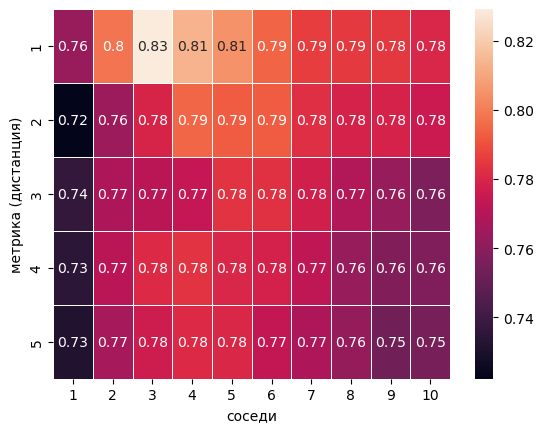

In [14]:
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

range_col = np.arange(1,11)
range_ind = np.arange(1,6)

grid_2d = [[np.mean(cross_val_score(
    Pipeline([
            ('preprocessing', RobustScaler()), 
            ('regressor',     KNeighborsRegressor(n_neighbors = n, p = k, weights = 'distance')
                   )]),
    X_train, y_train, cv = kfold)) for n in range_col] for k in range_ind]

prid_pd = pd.DataFrame(grid_2d, columns = range_col, index = range_ind)

s = sns.heatmap(prid_pd, annot=True, linewidths=.5)
s.set(xlabel='соседи', ylabel='метрика (дистанция)');

### Строим итоговую модель

В итоговом результате не нужно фиксировать `random_state` особенно в домашних задания и контрольных. Мы его фиксируем только для совпвдения результатов в учебной группе или статьях. 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

fin_pipe =  Pipeline([
            ('preprocessing', RobustScaler()), 
            ('regressor',     KNeighborsRegressor(n_neighbors = 3, p = 1, weights = 'distance'))
            ])
fin_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', RobustScaler()),
                ('regressor',
                 KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'))])

In [82]:
fin_pipe.score(X_train,y_train)

1.0

0.6777114848103254

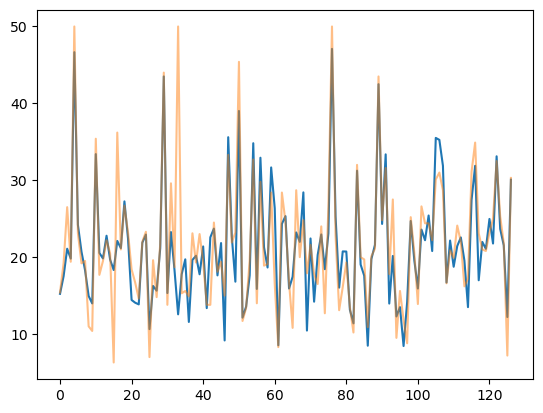

In [83]:
y_predict = fin_pipe.predict(X_test)
plt.plot(y_predict)
plt.plot(y_test, alpha=0.5)

fin_pipe.score(X_test,y_test)

In [77]:
X_test.shape

(127, 13)